<a href="https://colab.research.google.com/github/AngelescuFilip/multilabel_classification_sota/blob/main/Predicting_multilabel_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!nvidia-smi

Sat Jun 17 11:48:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |    129MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [53]:
import os
import matplotlib.pyplot as plt
from google.colab import drive

In [54]:
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
%%capture
!pip install transformers
!pip install pytorch-lightning
!pip install gradio jinja2
!pip install --upgrade git+https://github.com/JustAnotherArchivist/snscrape.git

In [56]:
import torch
import numpy as np
import pandas as pd

from torch.utils.data import Dataset

import pytorch_lightning as pl
from torch.utils.data import DataLoader

from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
# having your learning rate fixed is not that great
# so we want to have it decrease as we are getting closer to the optimal solution
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
# used in the official unhealthy comment corpus paper
import torch.nn.functional as F


In [57]:
from transformers import AutoTokenizer
model_name = 'distilroberta-base'

train_path = '/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv'
val_path = '/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/val.csv/val.csv'
attributes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [58]:
class Multilabel_Dataset(Dataset):

  def __init__(self, dataframe, tokenizer, attributes, max_token_len: int = 256, sample = 5000):
    self.dataframe = dataframe
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len
    self.sample = sample
    self._prepare_data()

  def _prepare_data(self):
    data = self.dataframe
    if self.sample is not None:
      unhealthy = data.loc[data[attributes].sum(axis=1) > 0]
      healthy = data.loc[data[attributes].sum(axis=1) == 0]
      self.data = pd.concat([unhealthy, healthy.sample(self.sample, random_state=7)])
    else:
      self.data = data

  def __len__(self):
    return(len(self.data))

  def __getitem__(self, index):
    item = self.data.iloc[index]
    comment = str(item.comment_text)
    attributes = torch.FloatTensor(item[self.attributes])
    tokens = self.tokenizer.encode_plus(comment,
                                        add_special_tokens=True,
                                        return_tensors='pt',
                                        truncation=True,
                                        max_length=self.max_token_len,
                                        padding='max_length',
                                        return_attention_mask=True)
    return {'input_ids': tokens.input_ids.flatten(), 'attention_mask': tokens.attention_mask.flatten(), 'labels': attributes}

In [59]:
class Multilabel_Data_Module(pl.LightningDataModule):

  def __init__(self, val_df, attributes, batch_size: int = 16, max_token_len: int = 256, model_name = model_name):
    super().__init__()
    self.val_df = val_df
    self.attributes = attributes
    self.batch_size = batch_size
    self.max_token_len = max_token_len
    self.model_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)

  def setup(self, stage = None):
    if stage == 'predict':
      self.val_dataset = Multilabel_Dataset(self.val_df, self.tokenizer, self.attributes, sample = None)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=2, shuffle = True)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle = False)

  def predict_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle = False)

In [60]:
val_df = pd.read_csv(val_path)

In [61]:
ml_data_module = Multilabel_Data_Module(val_df, attributes)

In [62]:
class Multilabel_Classifier(pl.LightningModule):

  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
    self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
    self.dropout = nn.Dropout()

  def forward(self, input_ids, attention_mask, labels=None):
    # roberta layer
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # final logits
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output)
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    # calculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("train loss ", loss, prog_bar = True, logger=True)
    return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}

  def validation_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("validation loss ", loss, prog_bar = True, logger=True)
    return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}

  def predict_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    return outputs

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.config['lr'])
    return optimizer

In [63]:
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 128,
    'lr': 1e-5,
    'warmup': 0.2,
    # 'train_size': len(ml_data_module.train_dataloader()),
    'weight_decay': 0.001,
    'n_epochs': 1
}

PATH = '/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/best_model_epochs_20_v2.pth'

In [64]:

data_loader = Multilabel_Data_Module(val_df, attributes=attributes)

model = Multilabel_Classifier(config)
model.load_state_dict(torch.load(PATH))

trainer = pl.Trainer()
model.eval()

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 

Multilabel_Classifier(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [65]:
# predictions = trainer.predict(model, data_loader)

In [66]:
# d1 = len(data_loader.val_dataloader())
# d1

In [67]:
val_df.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,78504,d20c7b96a357d4ad,"Your last version looks better, but I've resto...",0,0,0,0,0,0
1,3276,08d818efcc68caba,You just now made a bunch of reversions. Fuck,1,0,1,0,0,0
2,24361,4054f3474e721a32,"""\nUser:Jbrown 932\nThe user was reported at W...",0,0,0,0,0,0
3,62798,a80327cfd183f2d2,& discuss it on the talk page,0,0,0,0,0,0
4,67833,b57b106af05750e0,Minnie Minoso \n\nNo problem,0,0,0,0,0,0


# Predictions

In [68]:
# method to convert list of comments into predictions for each comment
def classify_raw_comments(model, dm):
  predictions = trainer.predict(model, datamodule=dm)
  flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flattened_predictions

In [69]:
predictions = classify_raw_comments(model, data_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [70]:
predictions

array([[6.92739286e-06, 2.64629180e-05, 1.49628948e-04, 2.46158161e-05,
        9.40786776e-05, 6.43272069e-05],
       [9.99824703e-01, 2.60257022e-03, 9.99565899e-01, 1.33580543e-04,
        5.25730522e-03, 2.10176040e-05],
       [2.97594786e-04, 7.81535928e-04, 9.93462086e-01, 4.13658621e-04,
        1.83507719e-03, 1.36788655e-03],
       ...,
       [6.11571653e-04, 4.47311650e-05, 2.34793290e-04, 6.39307473e-05,
        5.83406791e-06, 1.08164706e-04],
       [9.51019138e-06, 5.65442897e-05, 1.30841639e-04, 4.51677042e-05,
        7.48171879e-05, 1.58396637e-04],
       [9.73821104e-01, 5.84315392e-04, 5.20598471e-01, 2.90662836e-04,
        2.68861186e-04, 1.68101906e-04]], dtype=float32)

In [71]:
val_data = pd.read_csv(val_path)
true_labels = np.array(val_data[attributes])

Text(0.5, 1.0, 'RoBERTa Trained on UCC Datatset - AUC ROC')

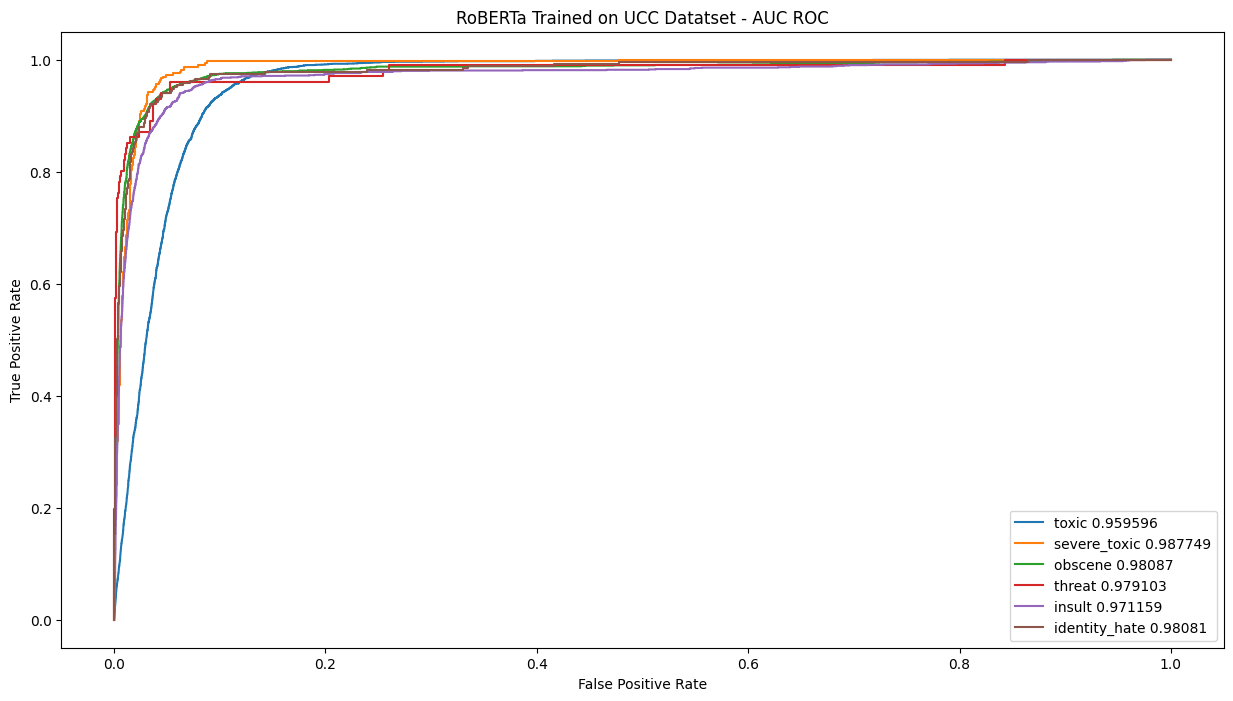

In [72]:
import matplotlib.pyplot as plt
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      true_labels[:,i].astype(int), predictions[:, i])
  auc = metrics.roc_auc_score(
      true_labels[:,i].astype(int), predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('RoBERTa Trained on UCC Datatset - AUC ROC')

# Testing the model predictions with a single comment

In [73]:
number_attributes = [0, 0, 0, 0, 0, 0]
comments = ['I will kill you!']
concat = [comments + number_attributes]
test = pd.DataFrame(concat, columns=['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
test_data_loader = Multilabel_Data_Module(test, attributes=attributes)
prediction = classify_raw_comments(model, test_data_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [74]:
text = ''
for i, attribute in enumerate(attributes):
  num = round(prediction[0][i], 4)
  text += '{}: {:.1%}\n'.format(attribute, num)
text

'toxic: 99.6%\nsevere_toxic: 4.1%\nobscene: 2.5%\nthreat: 99.8%\ninsult: 1.1%\nidentity_hate: 0.3%\n'

In [75]:
import gradio as gr

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


In [94]:
def score_comment(comment):
  comment = [comment]
  number_attributes = [0, 0, 0, 0, 0, 0]
  concat = [comment + number_attributes]
  test = pd.DataFrame(concat, columns=['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
  test_data_loader = Multilabel_Data_Module(test, attributes=attributes)
  prediction = classify_raw_comments(model, test_data_loader)

  text = ''
  for i, attribute in enumerate(attributes):
    num = round(prediction[0][i], 4)
    text += '{}: {:.1%}\n'.format(attribute, num)

  return text

In [95]:
comment = 'Fuck you'
score_comment(comment)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

'toxic: 100.0%\nsevere_toxic: 11.8%\nobscene: 100.0%\nthreat: 0.0%\ninsult: 79.1%\nidentity_hate: 0.0%\n'

In [96]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                         outputs='text')

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:30: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:30: UserWarning: `numeric` parameter is deprecated, and it has no effect
  super().__init__(


In [97]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f17aac24d6ae00a43b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# 1. Get Tweets

In [81]:
from tqdm.notebook import tqdm
import snscrape.modules.twitter as sntwitter

In [82]:
scraper = sntwitter.TwitterSearchScraper('#fishtankdotlive')

tweets = []
n_tweets = 50

for i, tweet in tqdm(enumerate(scraper.get_items()), total=n_tweets):
  data = [
      tweet.date,
      tweet.id,
      tweet.content,
      tweet.user.username,
      tweet.likeCount,
      tweet.retweetCount
  ]
  tweets.append(data)
  if i > n_tweets:
    break

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-82-2b914663864f>:10: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweet.content,


In [83]:
tweet_df = pd.DataFrame(tweets, columns=['date', 'id', 'tweet', 'username', 'like_count', 'retweet_count'])

In [84]:
tweet_df.head(10)

,date,id,tweet,username,like_count,retweet_count
0,2023-06-17 10:37:38+00:00,1670017856040235008,#dwarfism #BTS2023 #Bakhmut #BigHitProtectYour...,feet4444444,0,0
1,2023-06-17 01:53:39+00:00,1669885990557687809,#dwarfism #BTS2023 #Bakhmut #BigHitProtectYour...,feet4444444,1,1
2,2023-06-16 19:14:41+00:00,1669785586322767874,Erm...What the svengali #fishtanklive #fishtan...,RexPolaroyd,4,0
3,2023-06-16 17:28:21+00:00,1669758827397361665,the Johnny Sins of fishtank #fishtanklive #fis...,_brightlord,0,0
4,2023-06-16 16:50:00+00:00,1669749175263567872,What the Spruce?\nJosie washed her clothes in ...,DazeEmpty,0,0
5,2023-06-16 16:21:38+00:00,1669742037254516737,Mid off of the century:\n\nWho's more mid? (do...,joeyyfanclub,57,4
6,2023-06-16 16:12:38+00:00,1669739771315335168,Josie Happy Meal Mukbang and Toy Review https:...,DazeEmpty,0,0
7,2023-06-16 02:28:02+00:00,1669532253955710977,Still the funniest thing a person has done to ...,Ryan_Wynns,0,0
8,2023-06-16 02:25:07+00:00,1669531519302393856,#fishtankdotlive \n@wigger @jetneptune_\n\nhtt...,Ryan_Wynns,0,0
9,2023-06-15 04:04:27+00:00,1669194128888930305,Are you guys going to the FishTank theme park ...,fishheads2023,1,0


# 2. Preprocess

In [85]:
# remove hashtag ( # )
tweet_df['cleaned_tweet'] = tweet_df['tweet'].apply(lambda x: x.split('#')[0] if '#' in x else x)

In [86]:
# remove newline ( \n )
tweet_df['cleaned_tweet'] = tweet_df['tweet'].apply(lambda x: x.replace('\n', ' ').strip() if '\n' in x else x)

In [87]:
# remove at sign ( @ )
def whatistheremainder(v):
    remainderforone = v.split(' ', 1)
    outcome = remainderforone[1:][0]
    return outcome

tweet_df['cleaned_tweet'] = tweet_df['cleaned_tweet'].apply(lambda x: whatistheremainder(x) if '@' in x else x)

In [88]:
# remove tweets with no text
tweet_df['cleaned_tweet'].replace('', np.nan, inplace=True)
tweet_df.dropna(subset=['cleaned_tweet'], inplace=True)

In [89]:
tweet_df['cleaned_tweet'].head(10)

2                              Erm...What the svengali 
3                          the Johnny Sins of fishtank 
4     What the Spruce?\nJosie washed her clothes in ...
5     Mid off of the century:\n\nWho's more mid? (do...
6     Josie Happy Meal Mukbang and Toy Review https:...
7     Still the funniest thing a person has done to ...
9     Are you guys going to the FishTank theme park ...
10              https://t.co/Cotq0r9P5v\nChip Smokes.\n
11                   Holy shit, Carl should've been on 
12    Summary:Josie is the reincarnation of Ciara ev...
Name: cleaned_tweet, dtype: object

In [90]:
tweet_df.head(30)

,date,id,tweet,username,like_count,retweet_count,cleaned_tweet
2,2023-06-16 19:14:41+00:00,1669785586322767874,Erm...What the svengali #fishtanklive #fishtan...,RexPolaroyd,4,0,Erm...What the svengali
3,2023-06-16 17:28:21+00:00,1669758827397361665,the Johnny Sins of fishtank #fishtanklive #fis...,_brightlord,0,0,the Johnny Sins of fishtank
4,2023-06-16 16:50:00+00:00,1669749175263567872,What the Spruce?\nJosie washed her clothes in ...,DazeEmpty,0,0,What the Spruce?\nJosie washed her clothes in ...
5,2023-06-16 16:21:38+00:00,1669742037254516737,Mid off of the century:\n\nWho's more mid? (do...,joeyyfanclub,57,4,Mid off of the century:\n\nWho's more mid? (do...
6,2023-06-16 16:12:38+00:00,1669739771315335168,Josie Happy Meal Mukbang and Toy Review https:...,DazeEmpty,0,0,Josie Happy Meal Mukbang and Toy Review https:...
7,2023-06-16 02:28:02+00:00,1669532253955710977,Still the funniest thing a person has done to ...,Ryan_Wynns,0,0,Still the funniest thing a person has done to ...
9,2023-06-15 04:04:27+00:00,1669194128888930305,Are you guys going to the FishTank theme park ...,fishheads2023,1,0,Are you guys going to the FishTank theme park ...
10,2023-06-15 21:41:00+00:00,1669460019681665025,https://t.co/Cotq0r9P5v\nChip Smokes.\n#fishta...,KennyRiots,1,0,https://t.co/Cotq0r9P5v\nChip Smokes.\n
11,2023-06-16 02:23:24+00:00,1669531088518086656,"Holy shit, Carl should've been on #fishtankdot...",Ryan_Wynns,0,0,"Holy shit, Carl should've been on"
12,2023-06-14 18:43:47+00:00,1669053034838515715,Summary:Josie is the reincarnation of Ciara ev...,RexPolaroyd,12,0,Summary:Josie is the reincarnation of Ciara ev...
